In [69]:
options(warn = -1)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))

In [70]:
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')
sce <- readRDS('h5ad/df.fil3_gex_bcells_vdj_sce_B_mem_all_230622.RDS')
counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age
min_cells = 10
# remove samples >21 days
sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
# Remove samples with less than 10 cells
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
sce2 <- sce2[, !sce2$sample_id %in% rmSamples]
# remove negatives and recoveries
sce3 <- sce2[,sce2$case_control == 'POSITIVE']
sce3

class: SingleCellExperiment 
dim: 32913 9235 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(9235): UK-CIC10689738+UK-CIC10690026_AAGGTTCGTGCGCTTG-1
  UK-CIC10689738+UK-CIC10690026_AGCAGCCTCTTCGAGA-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTACTGAGGTGGGTT-1
  UK-CIC10690384+UK-CIC10690576_TTTATGCTCCTCAATT-1
colData names(75): orig.ident nCount_RNA ... grouped_severity
  age_scaled
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [71]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce3, id = as.character(colData(sce3)[, c("sample_id")]))
smrzd <- logNormCounts(smrzd)
smrzd

class: SingleCellExperiment 
dim: 32913 125 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(125): C101_1101 C101_1301 ... C93_2104 C93_2704
colData names(78): orig.ident nCount_RNA ... ncells sizeFactor
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [72]:
unique(smrzd$centre)

[1] Cambridge NCL      
Levels: Cambridge NCL

In [73]:
# add vaccination info
vacc <- read.csv('vaccination.csv')
# all wave 1 are unvaccinated
smrzd$vaccine <- FALSE
smrzd$vaccine[smrzd$centre == 'Cambridge'] <- NA
smrzd$vaccine <- vacc$vaccine[match(smrzd$individual_id, vacc$individual_id)]
# adjust the individuals that are found in both waves
smrzd$vaccine[smrzd$individual_id %in% c('C101', 'C108', 'C137', 'C138', 'C140', 'C141', 'C145', 'C146', 'C147', 'C168', 'C169', 'C170', 'C187', 'C190', 'C33') & smrzd$centre == 'NCL'] <- FALSE
smrzd$vaccine[smrzd$centre == 'NCL'] <- FALSE
smrzd$vaccine

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [37]  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE
 [61]  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73] FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE

In [74]:
## subset to waves
wave1 <- smrzd[,smrzd$centre == 'NCL']
wave2 <- smrzd[,smrzd$centre == 'Cambridge']

In [75]:
length(table(droplevels(wave1$individual_id)))

[1] 21

In [76]:
length(table(droplevels(wave2$individual_id)))

[1] 15

In [77]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    (1 | individual_id)

### Run the spline model but on gene sets

### Hallmark

In [78]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [79]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

In [80]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

In [81]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data1))
    return(list(fit=fit, data=data1))
})

In [82]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [83]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[6,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df1 = df1[df1$pvals < 0.05 & df1$conv == 0,]
df1

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_KRAS_SIGNALING_DN28,0.01112554,0.556277,0,0


In [84]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


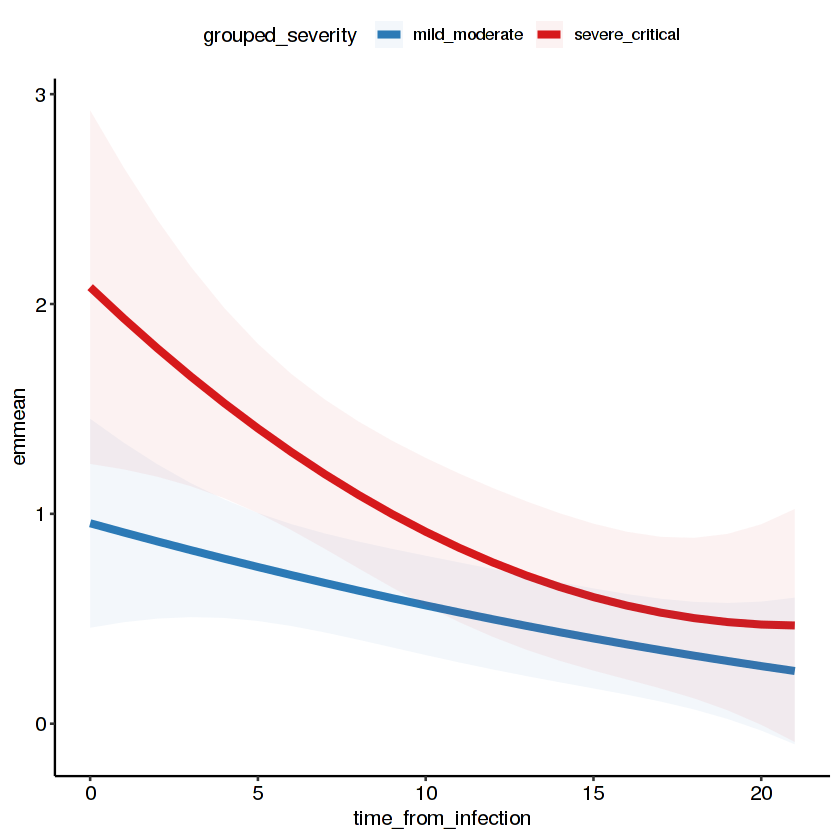

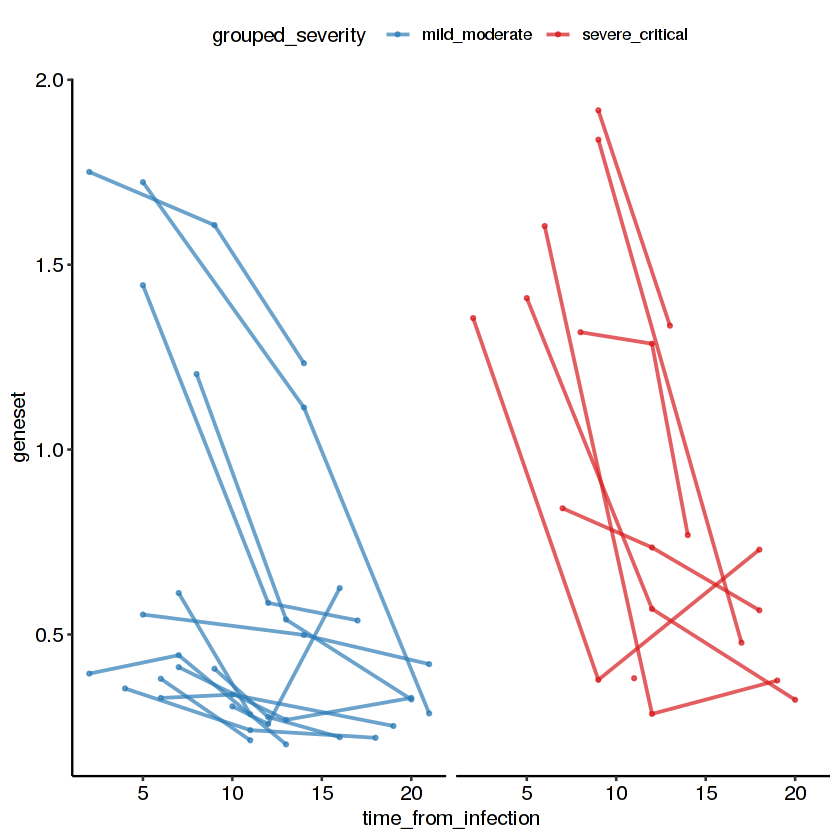

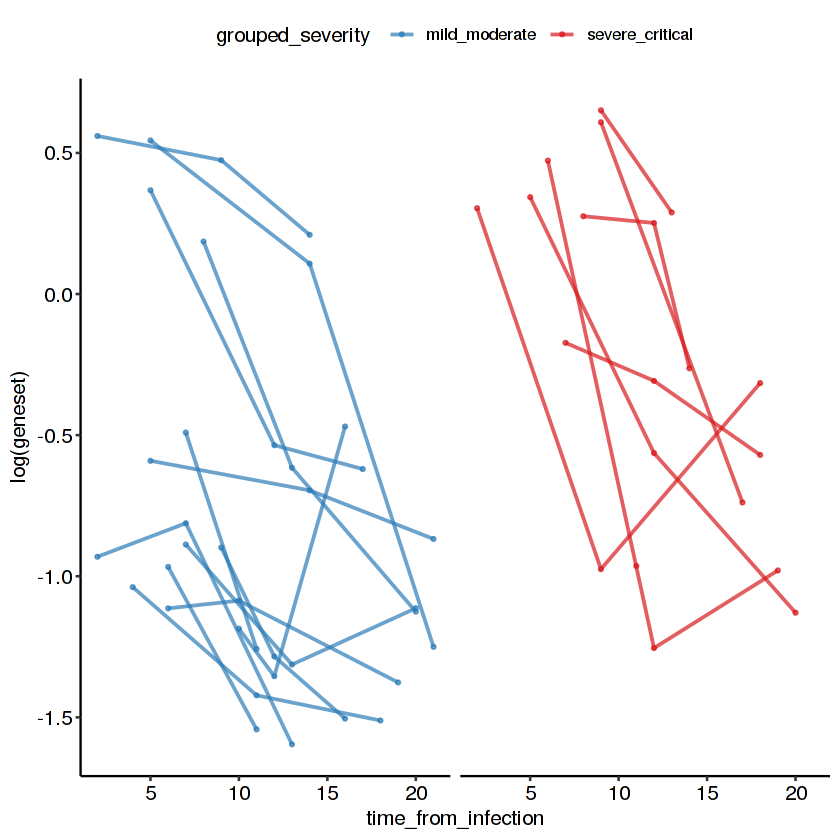

In [85]:
i = 26
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

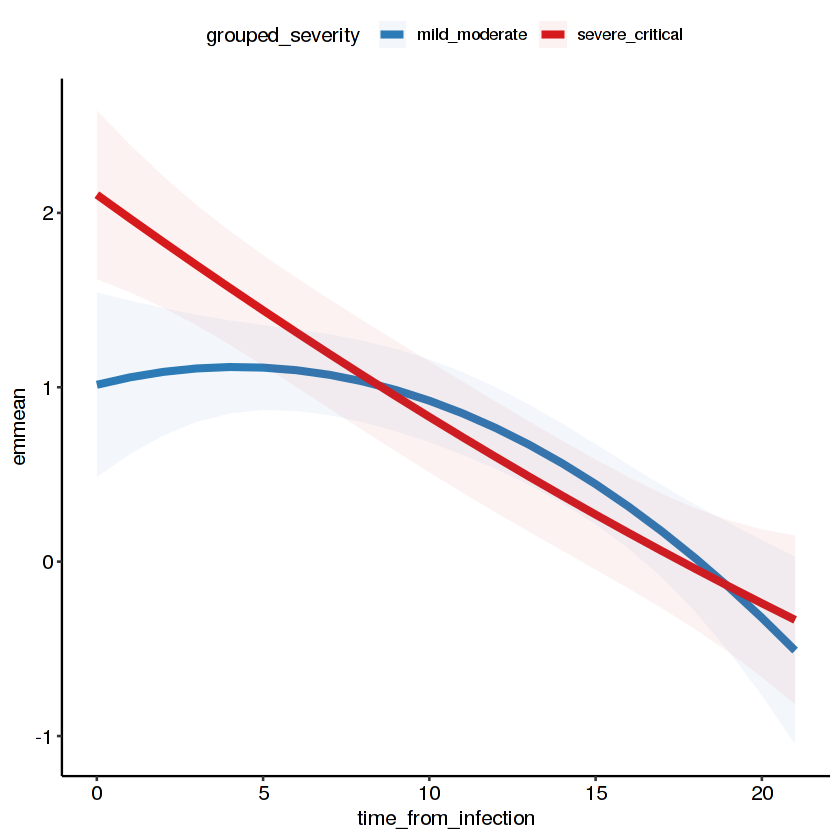

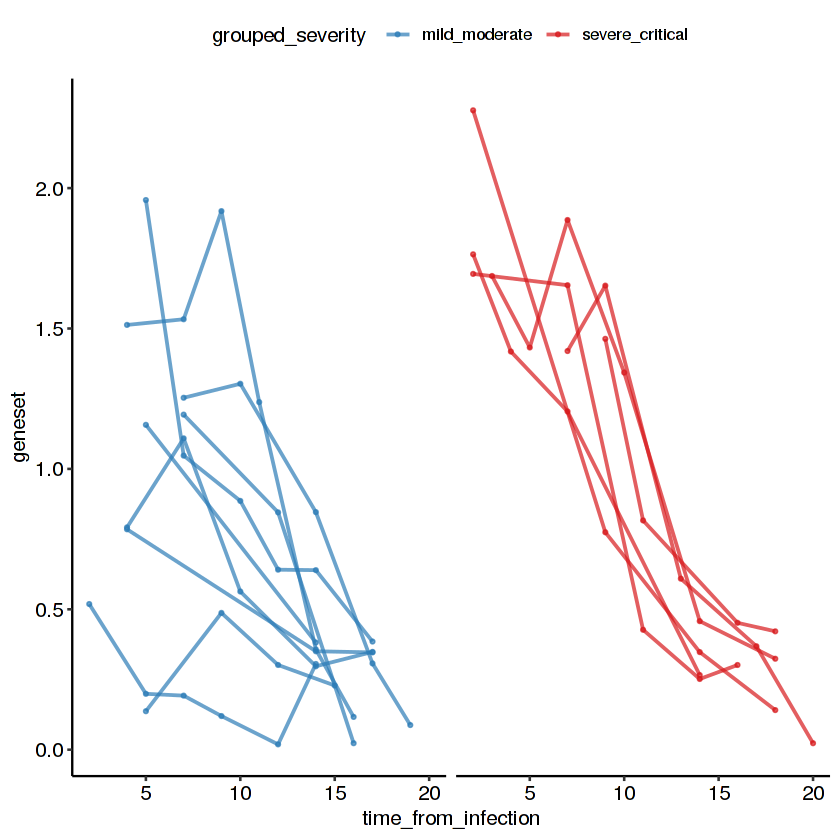

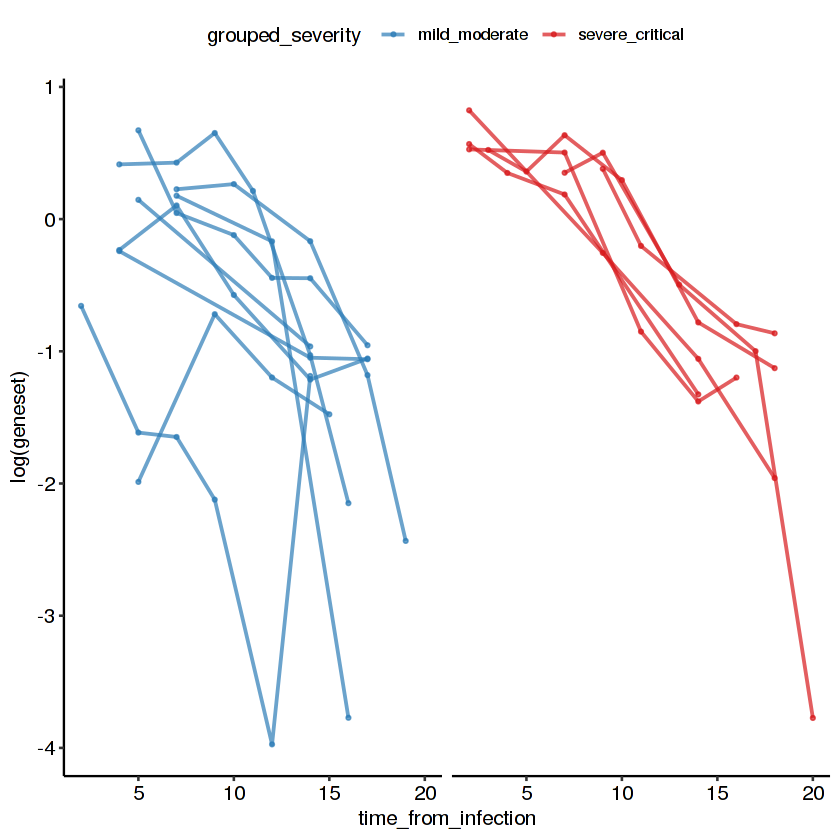

In [86]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

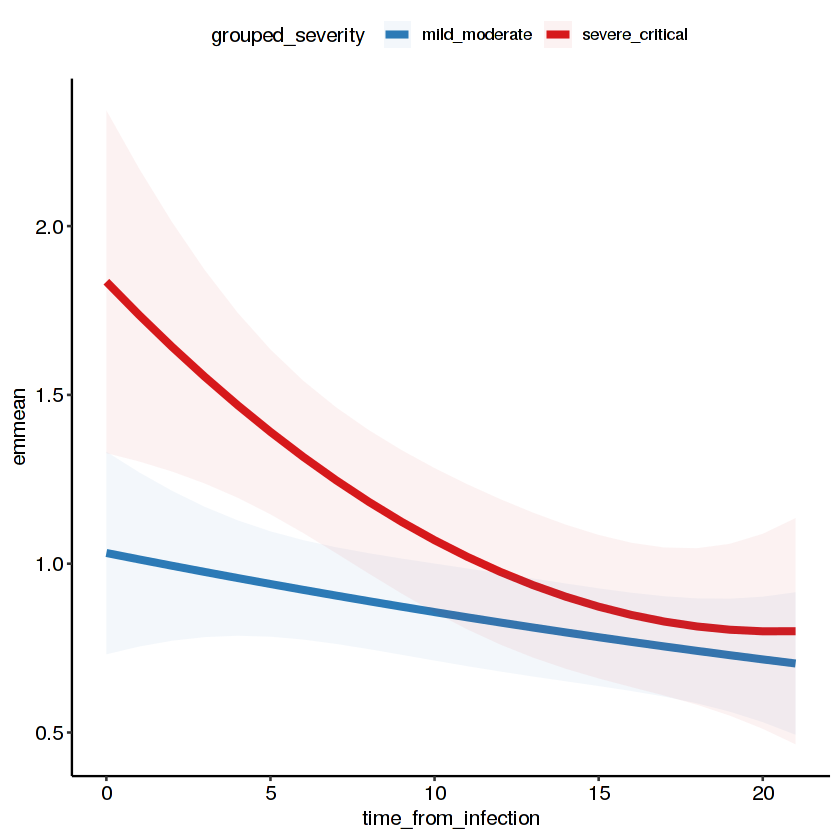

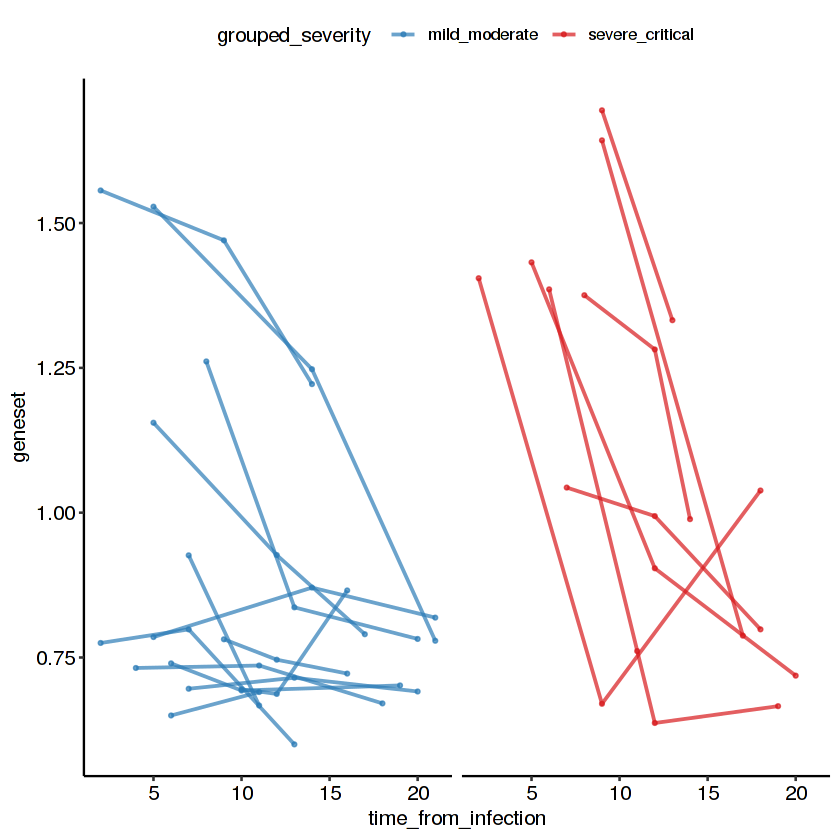

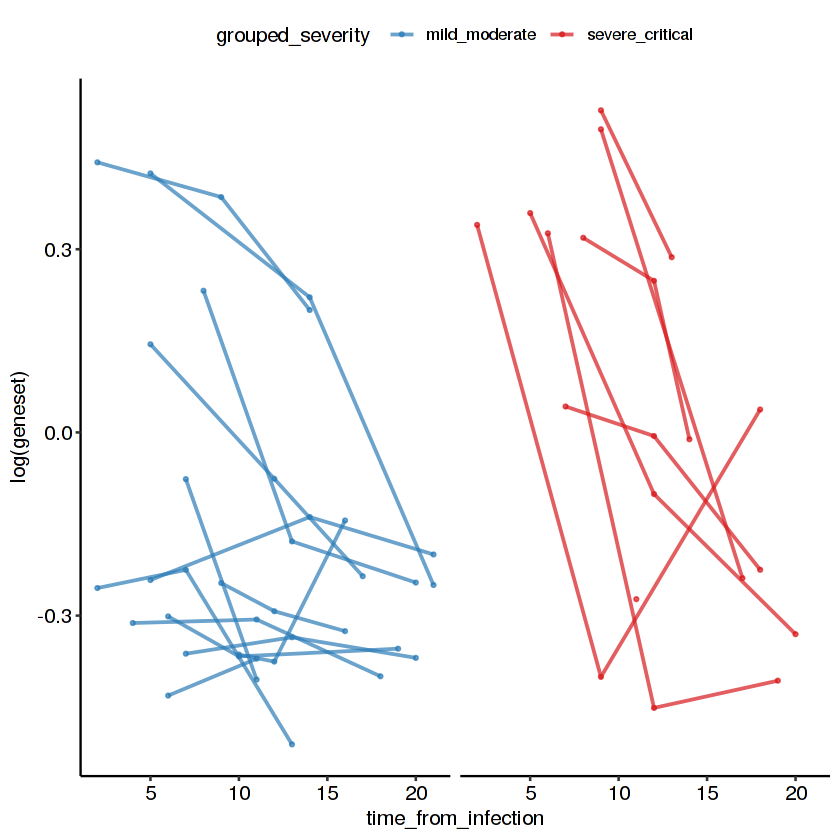

In [87]:
i = 27
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

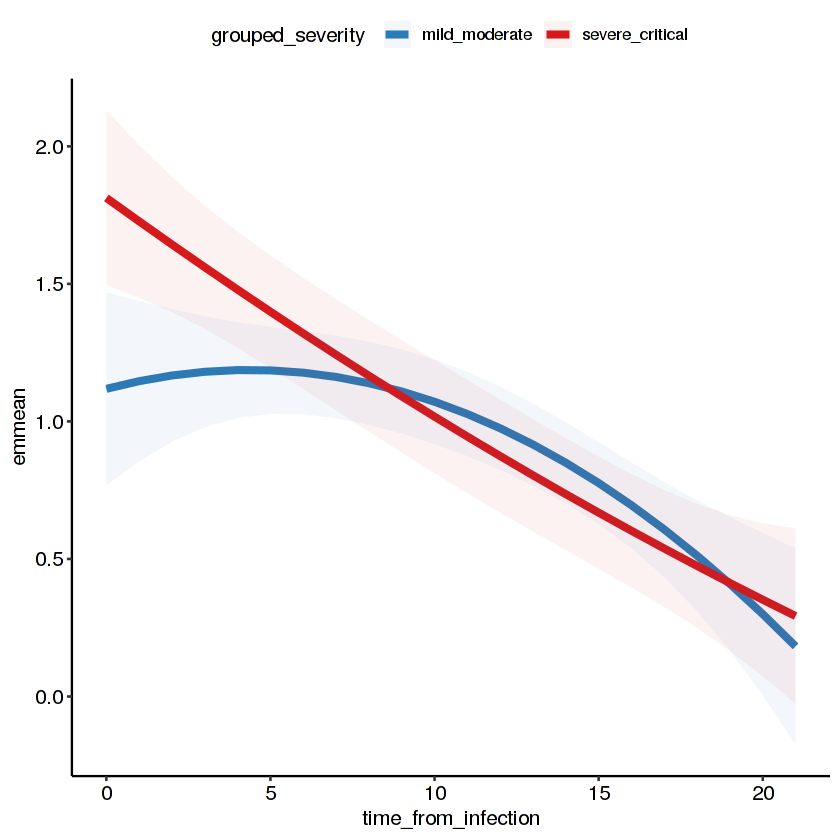

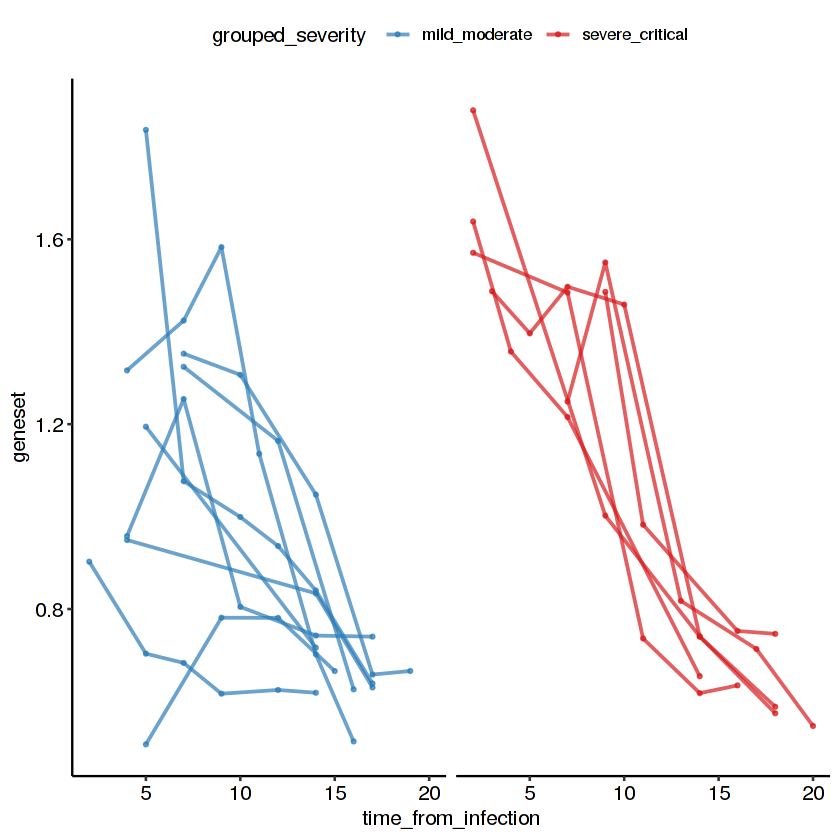

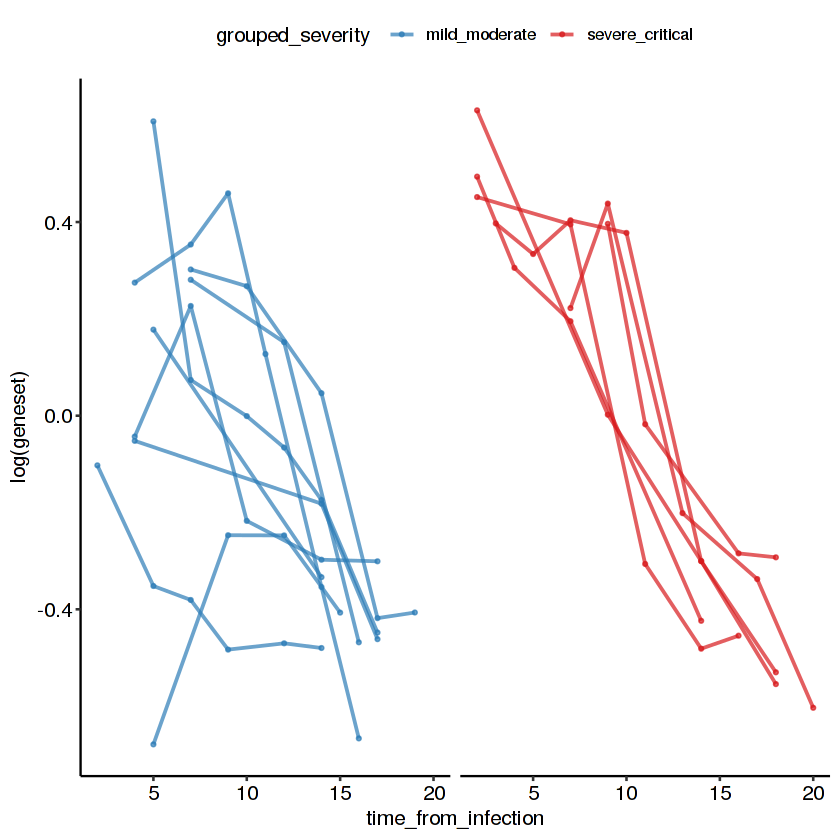

In [88]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### KEGG

In [89]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [90]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

In [91]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

In [92]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data1))
    return(list(fit=fit, data=data1))
})

In [93]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [94]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[6,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df1 = df1[df1$pvals < 0.05 & df1$conv == 0,]
df1

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY4,0.03912922,0.911201,0,0
KEGG_CALCIUM_SIGNALING_PATHWAY30,0.02307612,0.911201,0,0
KEGG_LONG_TERM_POTENTIATION94,0.04802990,0.911201,0,0
KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION125,0.01704546,0.911201,0,0


In [95]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
KEGG_THYROID_CANCER171,0.04497313,0.9971676,0,0


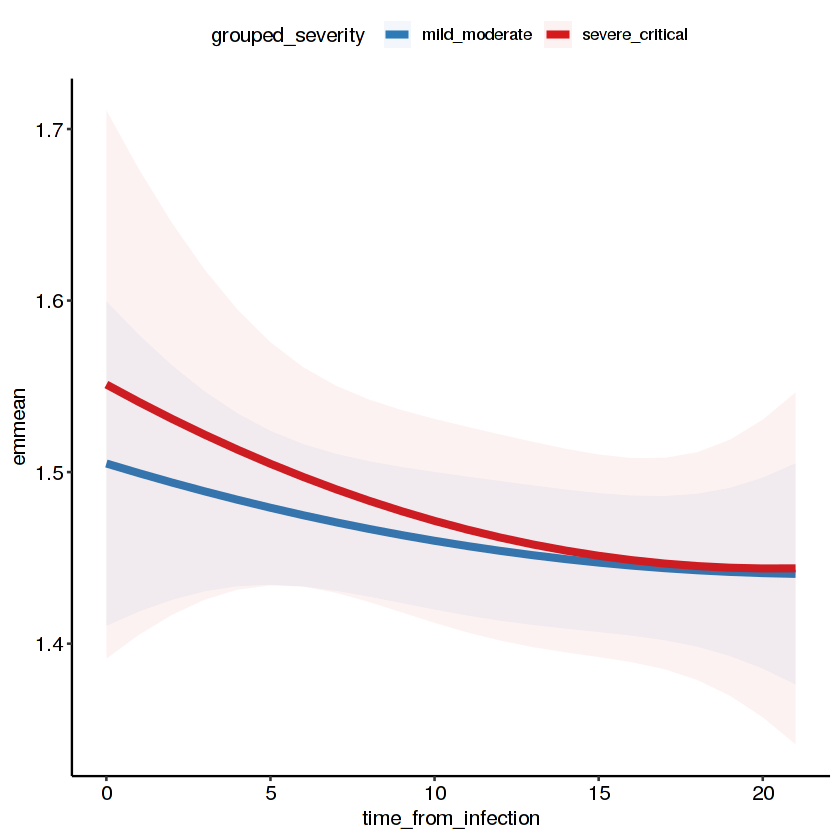

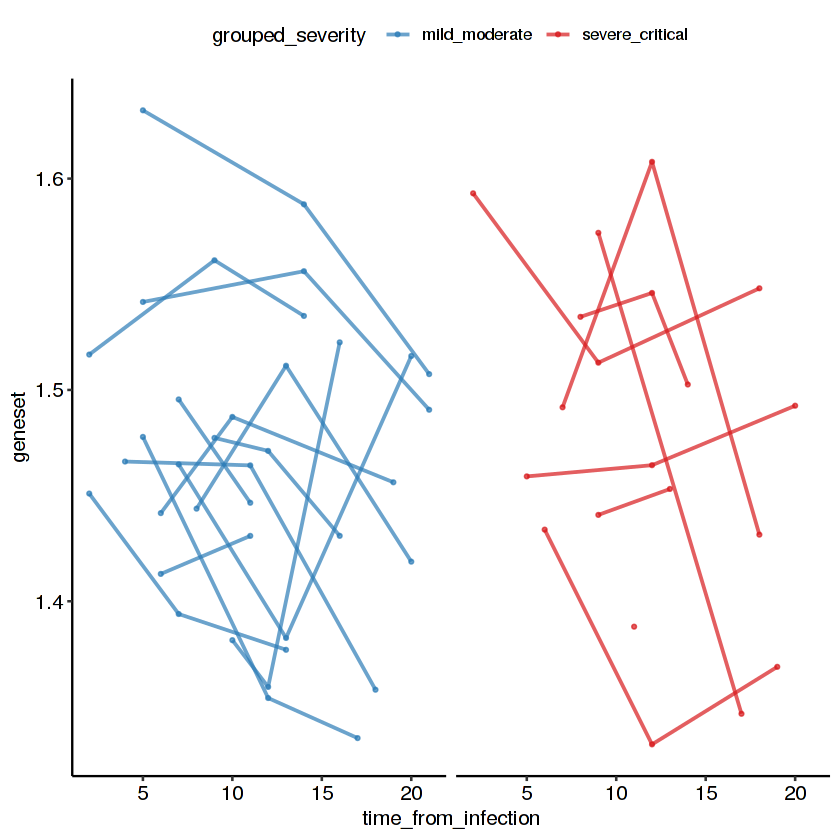

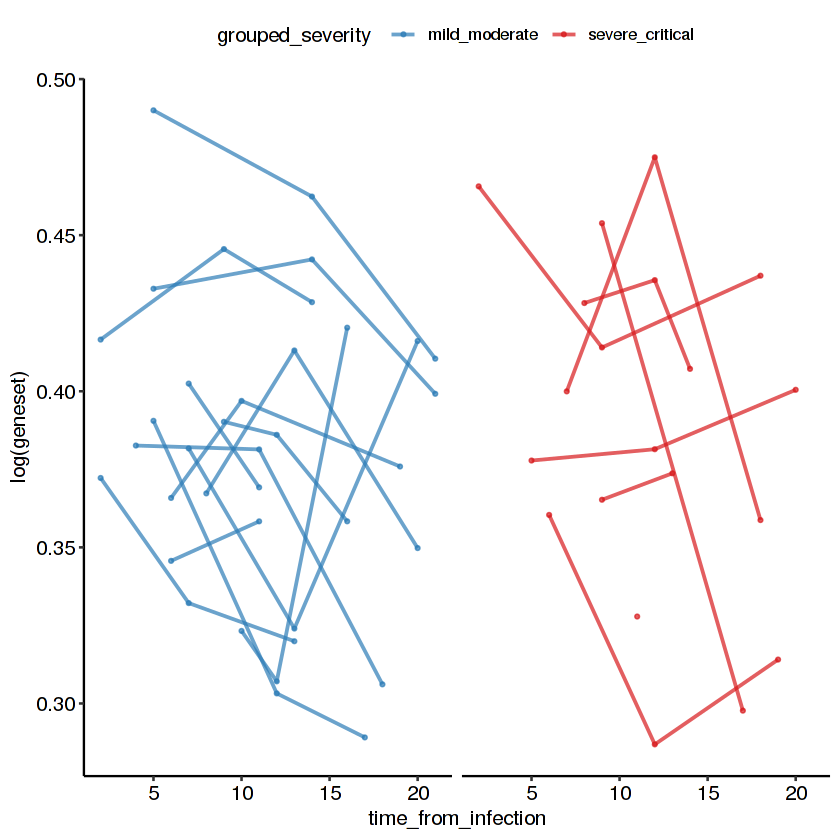

In [96]:
i = 13
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

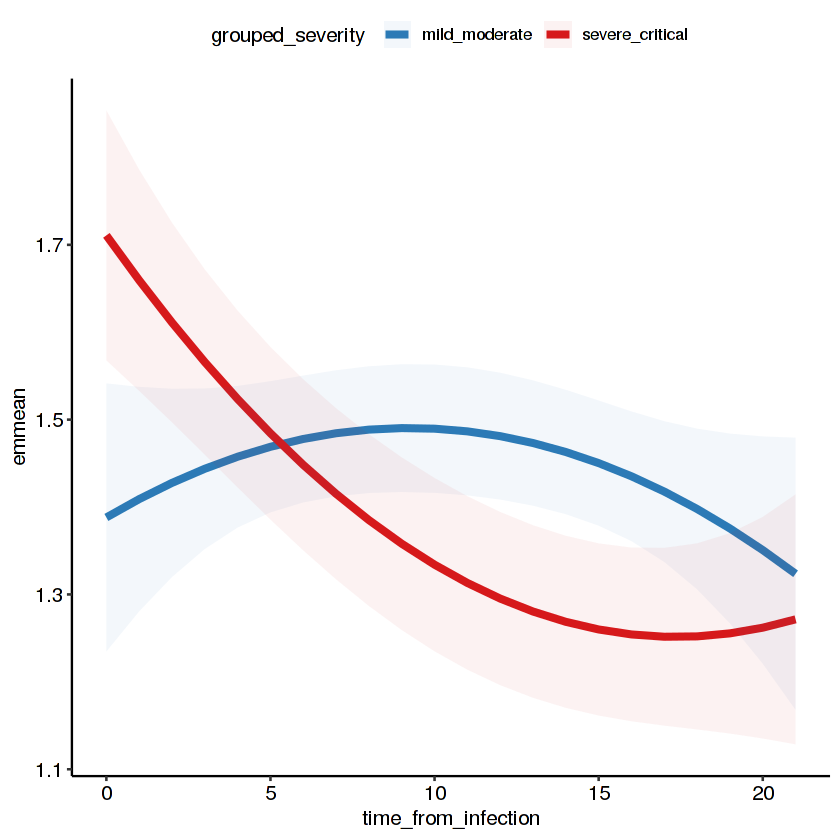

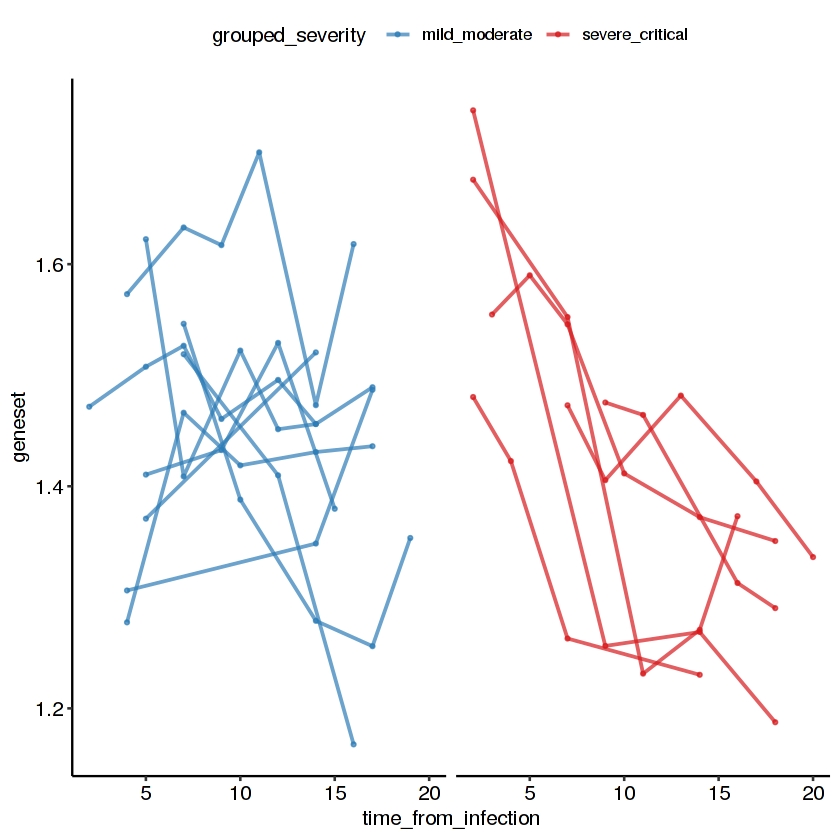

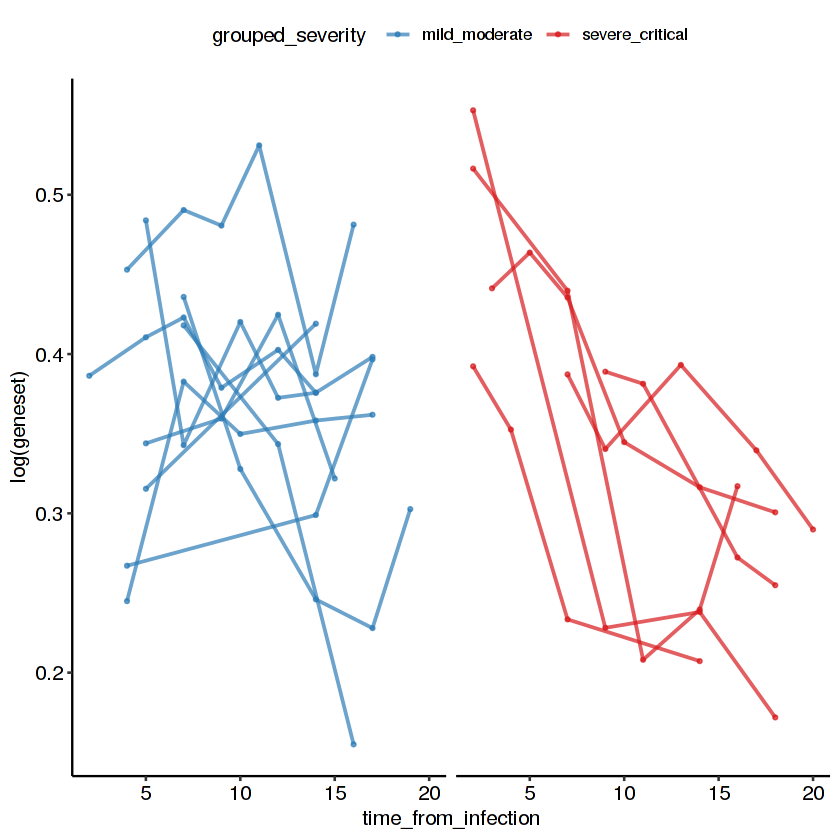

In [97]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### add vaccination as an interaction but for wave2 only

In [98]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * vaccine + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * vaccine + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    (1 | individual_id)

In [99]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [100]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_HEME_METABOLISM21,0.03077903,0.7694758,0,0


In [101]:
names(genelists)[26]

[1] "HALLMARK_INTERFERON_ALPHA_RESPONSE"

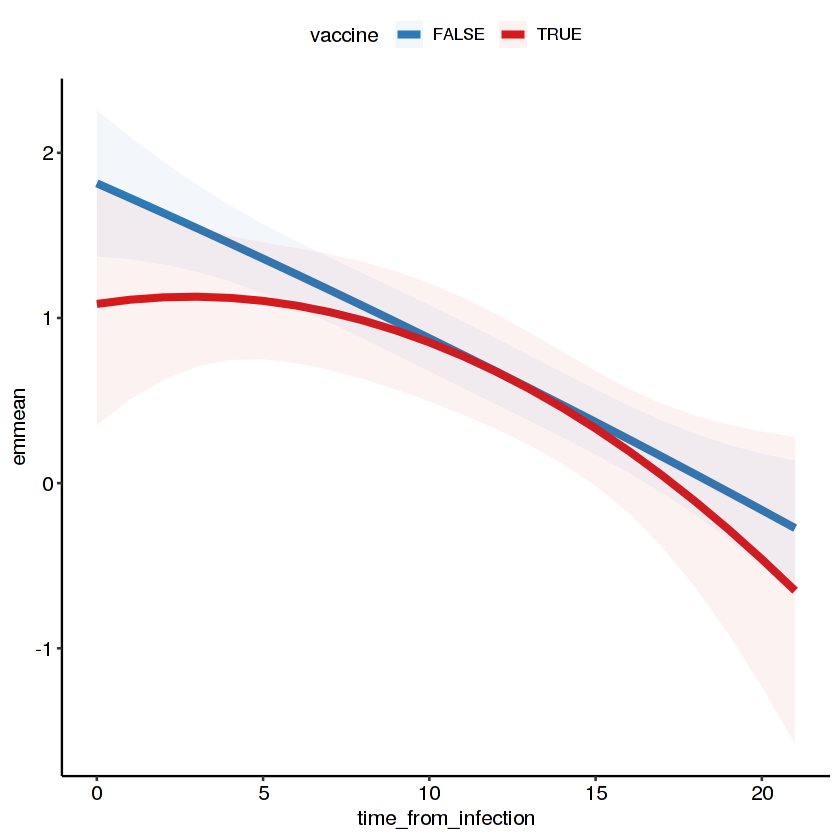

In [102]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

In [103]:
# ggplot(fits2[[26]]$data, aes(time_from_infection, geneset, col = vaccine)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~vaccine) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

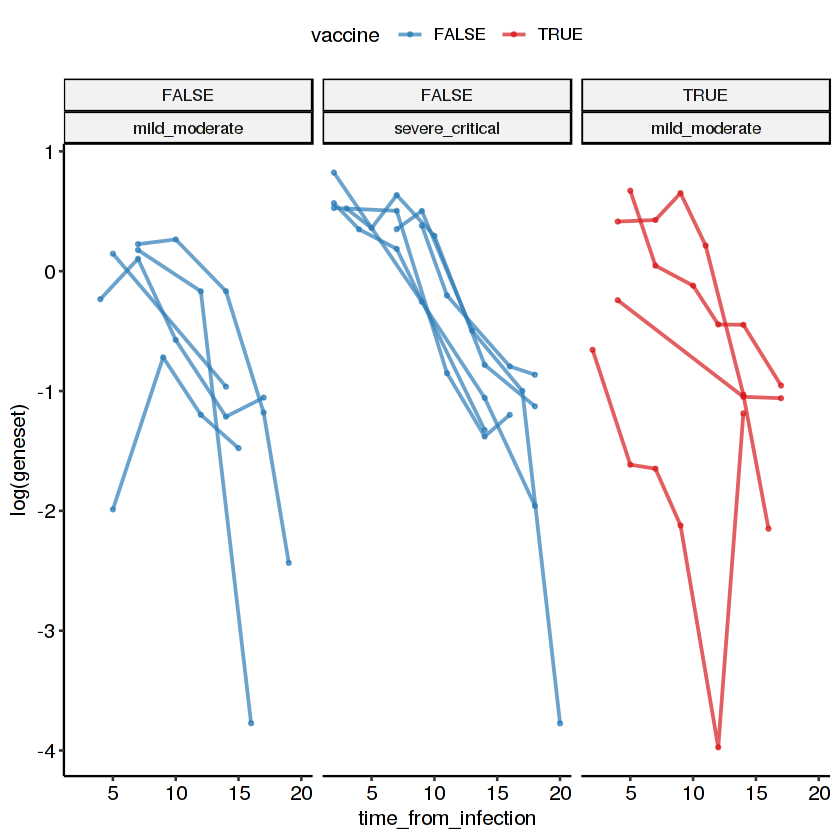

In [104]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

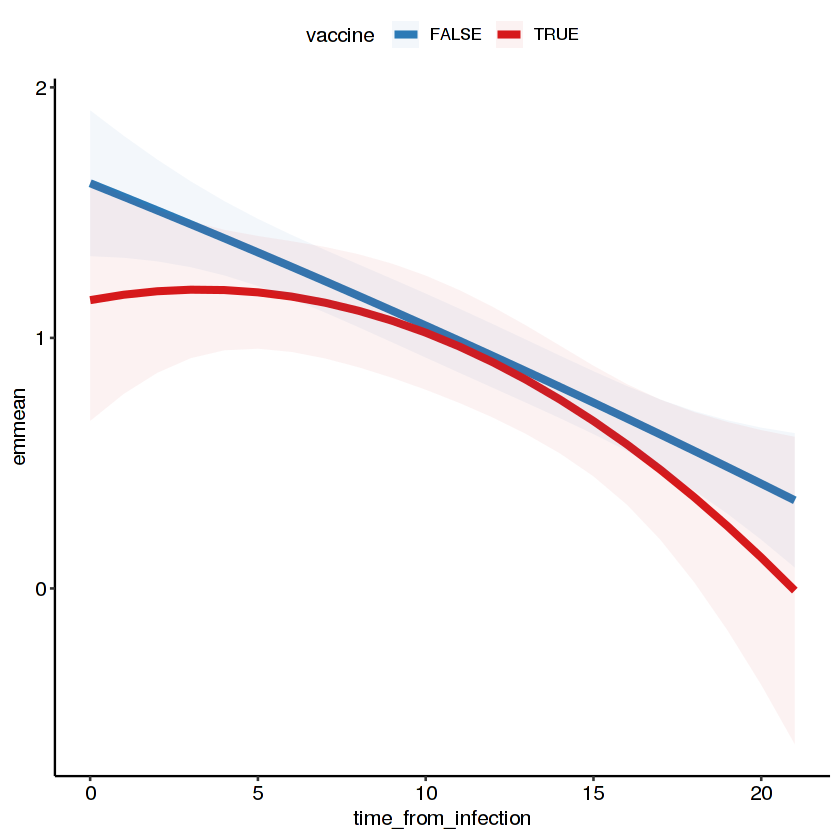

In [105]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

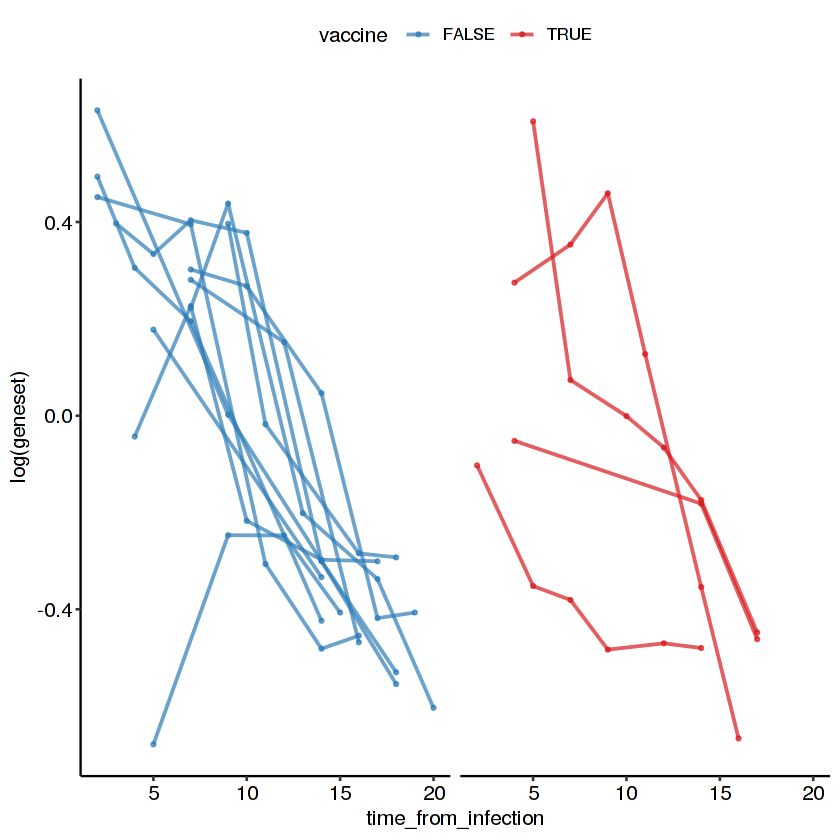

In [106]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

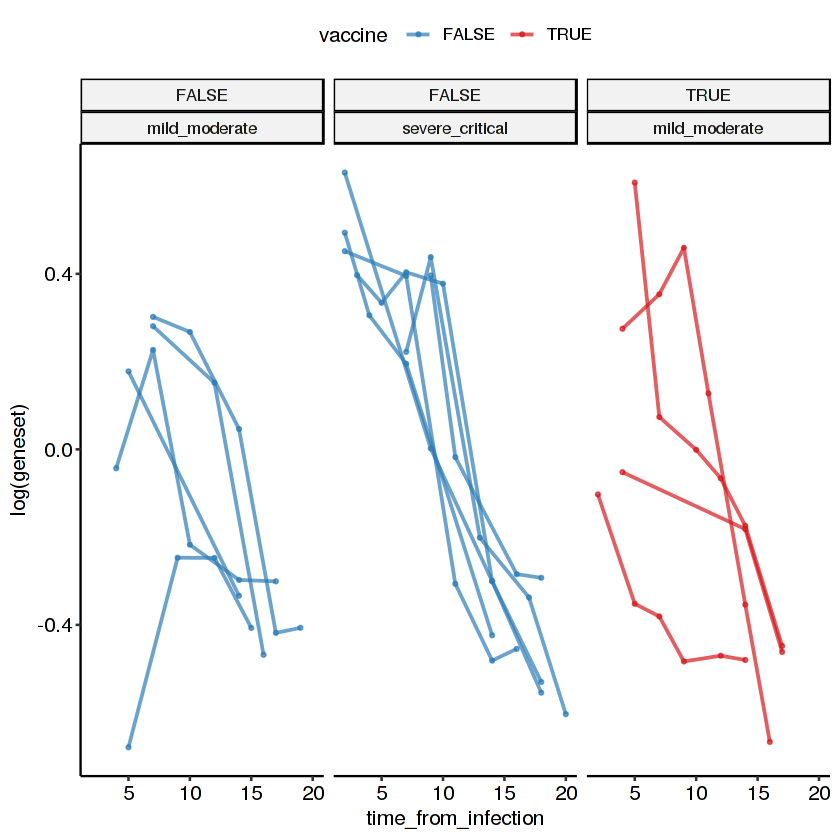

In [107]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [108]:
## kegg
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [109]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
KEGG_OLFACTORY_TRANSDUCTION116,0.02886118,0.9824149,0,0
KEGG_PORPHYRIN_AND_CHLOROPHYLL_METABOLISM132,0.04301024,0.9824149,0,0


In [110]:
names(genelists)[13]

[1] "KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION"

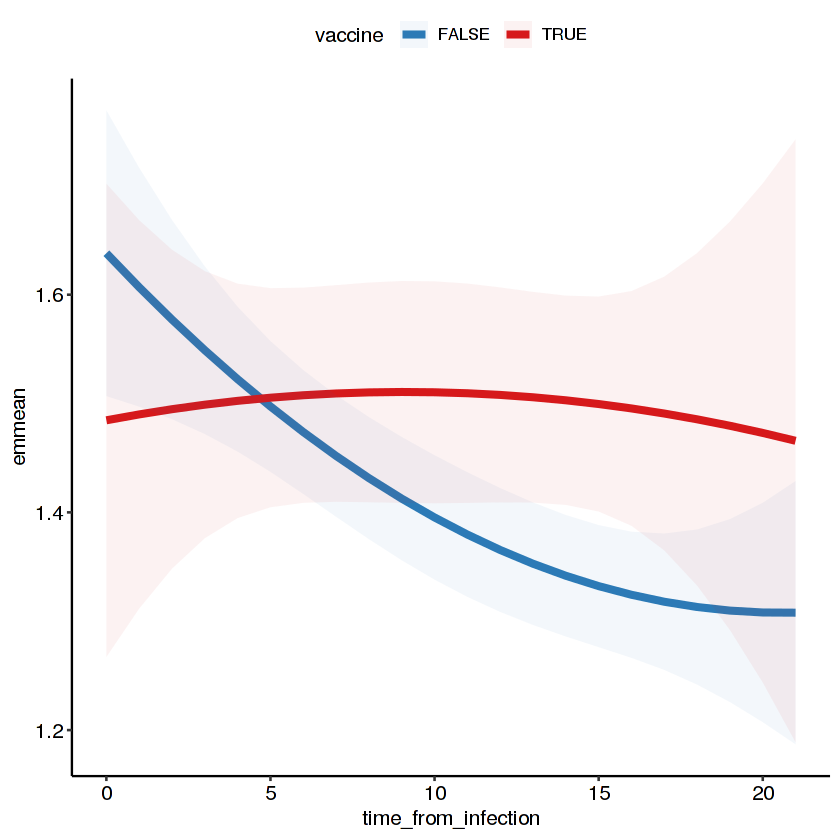

In [111]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

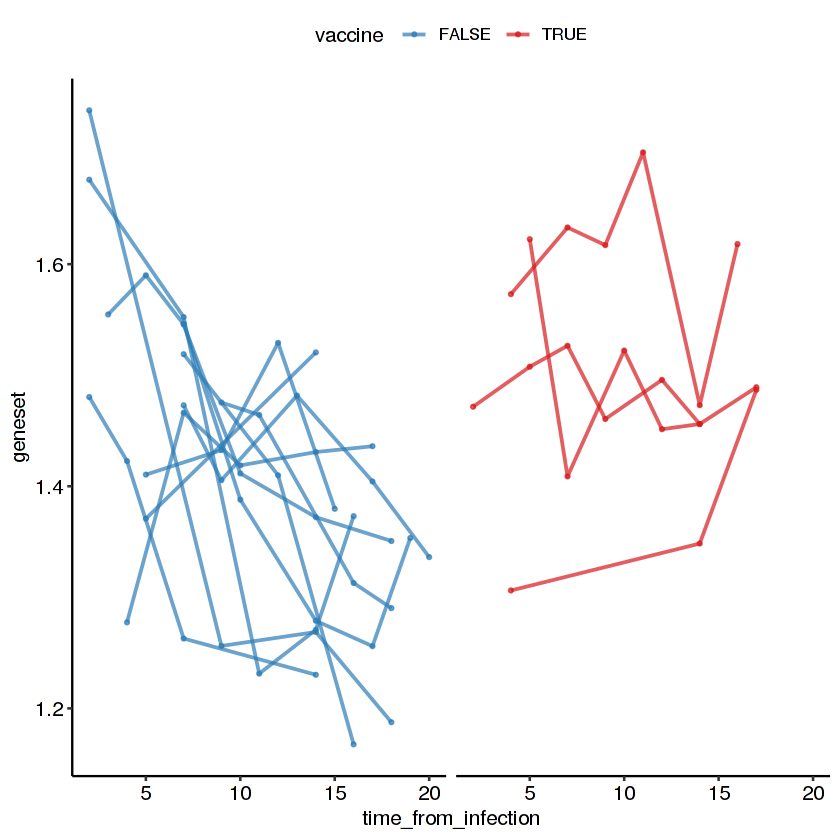

In [112]:
ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

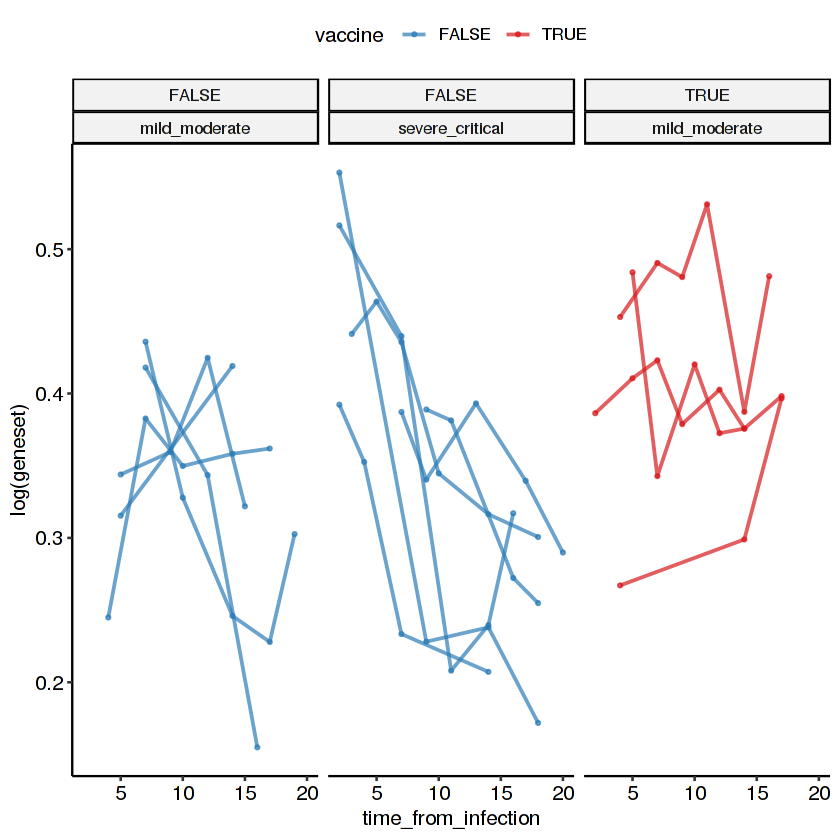

In [113]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [114]:
names(genelists)[[25]]

[1] "KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY"

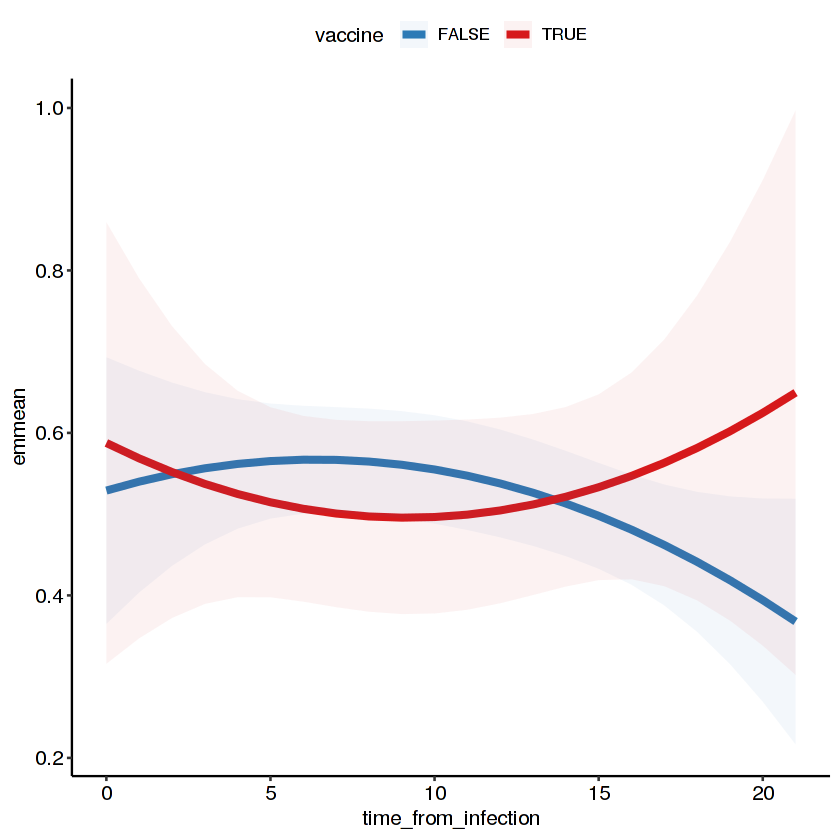

In [115]:
i = 25
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

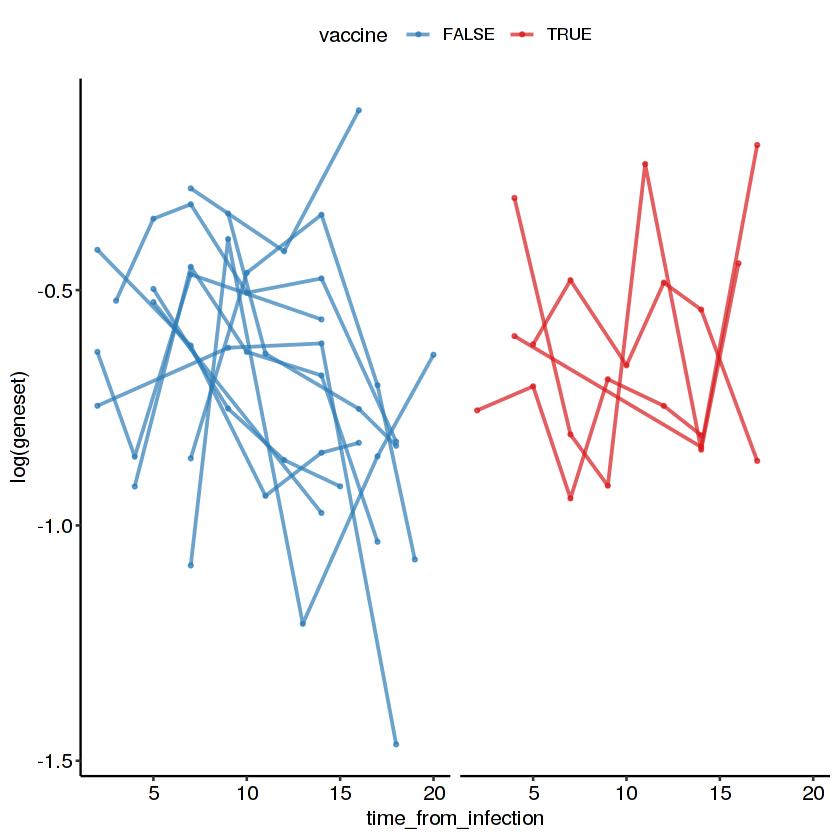

In [116]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

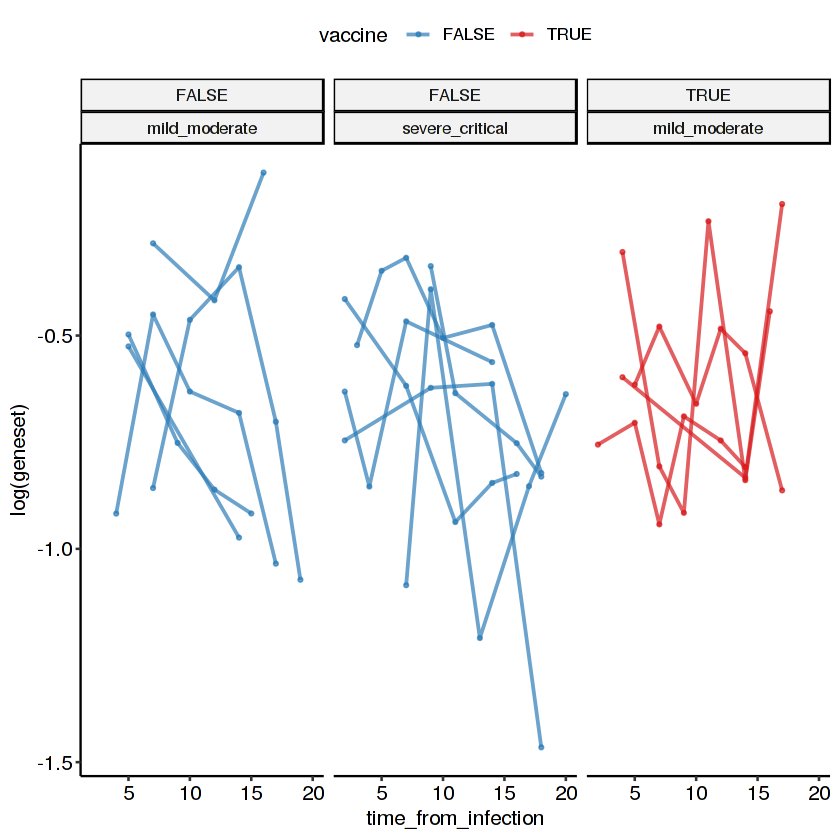

In [117]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### Repeat but only mild_moderate

In [118]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
# subset to just mild_moderate
seu2 <- subset(seu2, subset = grouped_severity == 'mild_moderate')
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [119]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [120]:
names(genelists)[26]

[1] "HALLMARK_INTERFERON_ALPHA_RESPONSE"

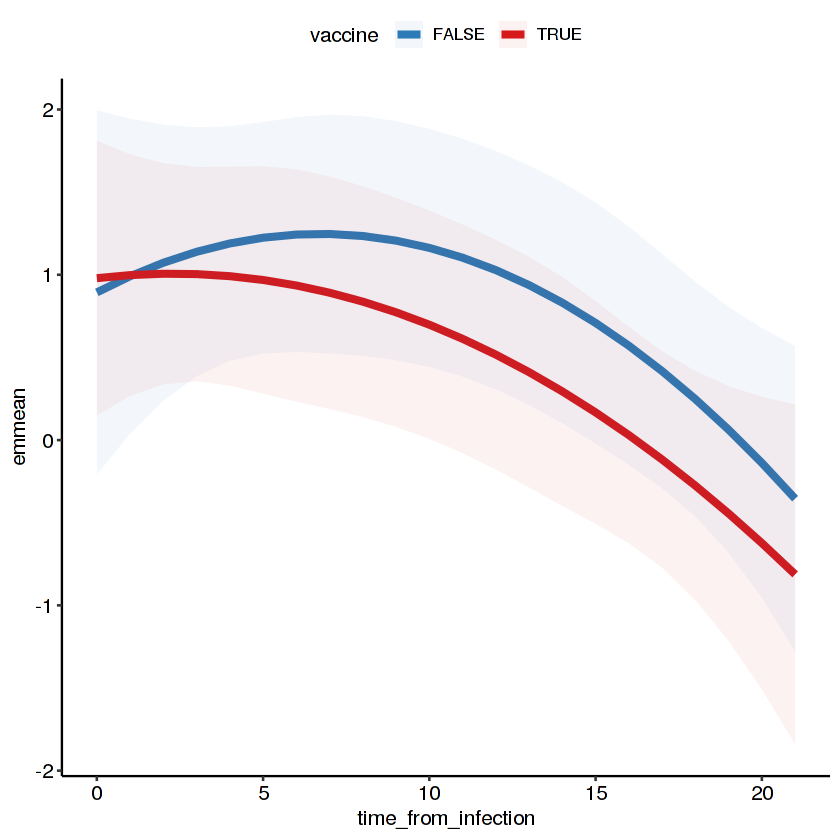

In [121]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

In [122]:
# ggplot(fits2[[26]]$data, aes(time_from_infection, geneset, col = vaccine)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~vaccine) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

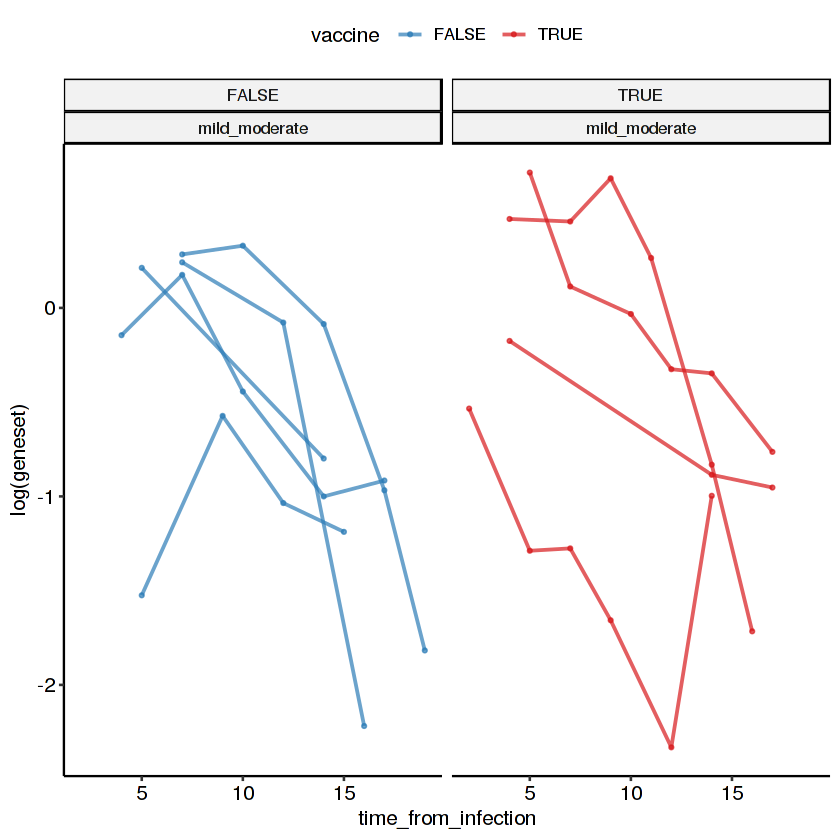

In [123]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

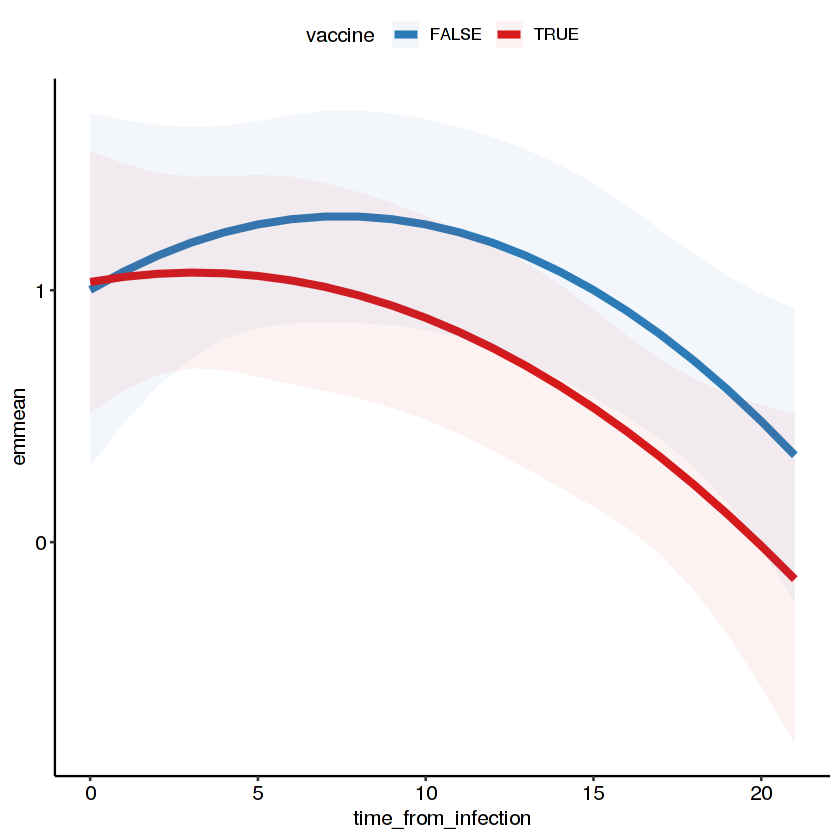

In [124]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

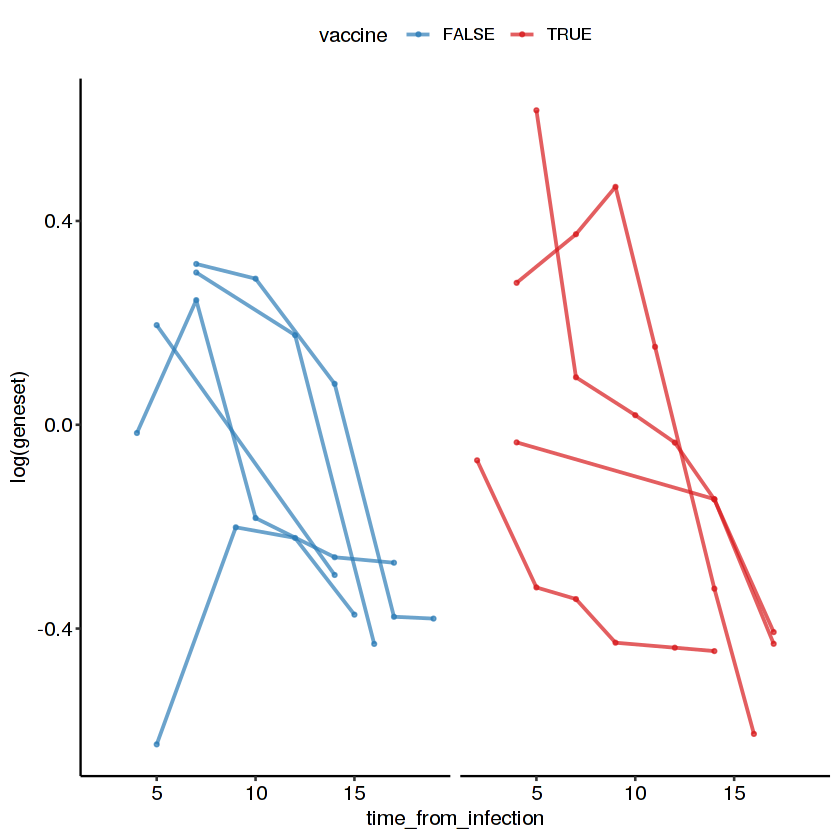

In [125]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

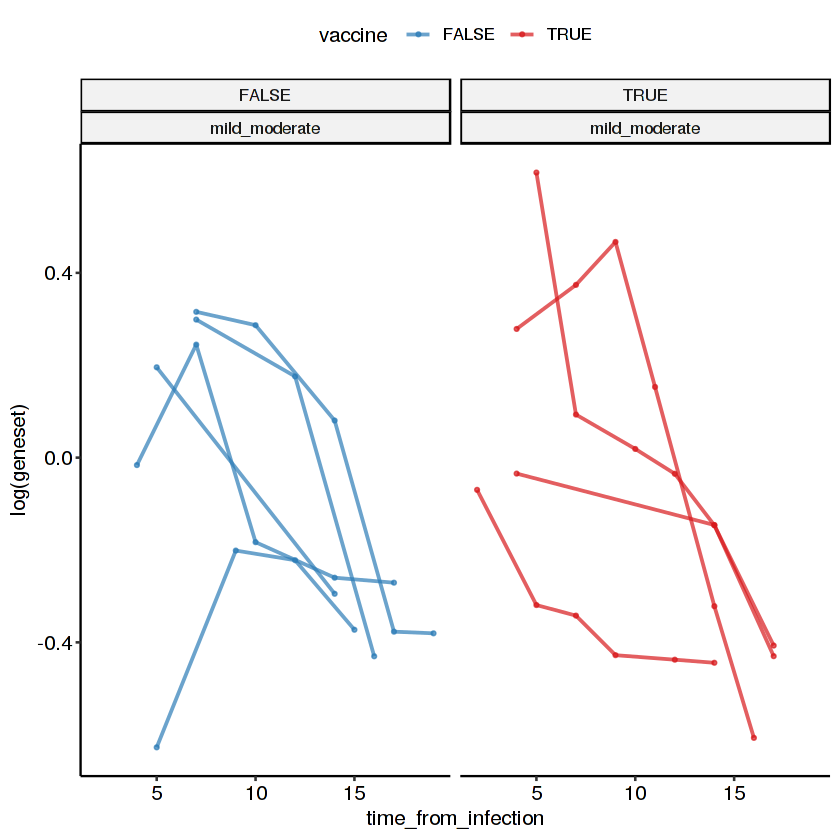

In [126]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [127]:
## kegg
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)
seu2 <- as.Seurat(wave2)
# subset to just mild_moderate
seu2 <- subset(seu2, subset = grouped_severity == 'mild_moderate')
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))               
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- suppressMessages(lmerTest::lmer(fullFormula, data = data2))
    return(list(fit=fit, data=data2))
})

In [128]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$pvals < 0.05 & df2$conv == 0,]
df2

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [129]:
names(genelists)[13]

[1] "KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION"

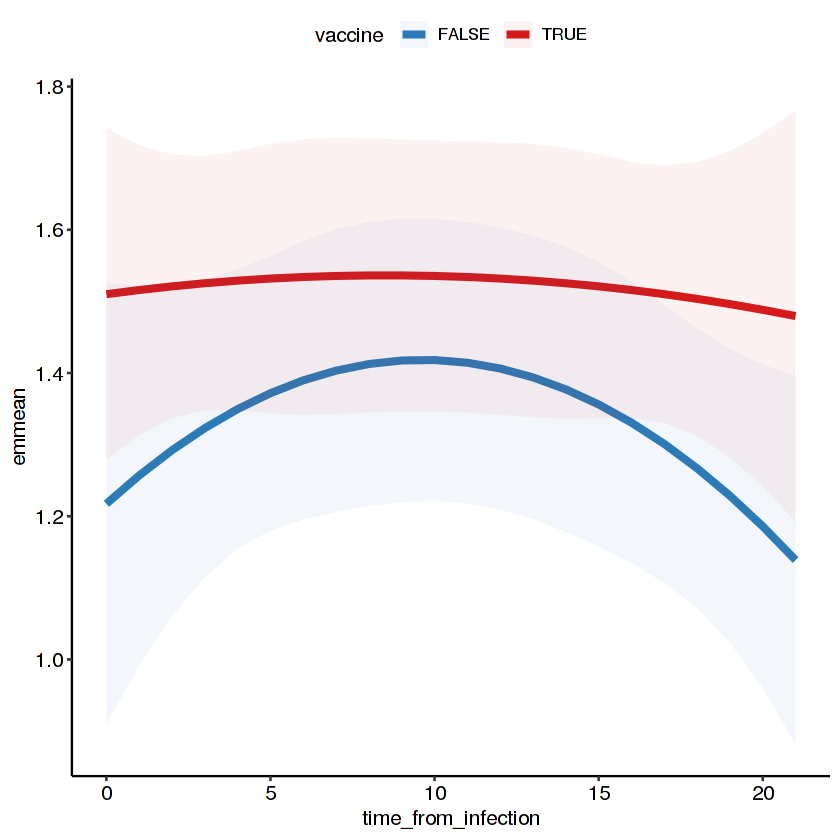

In [130]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

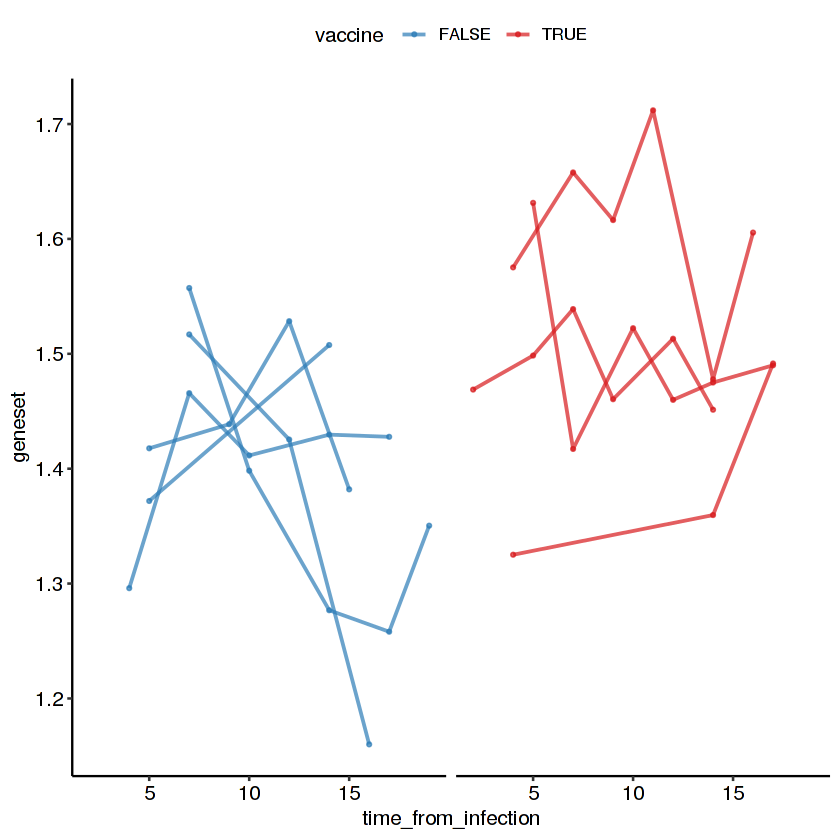

In [131]:
ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

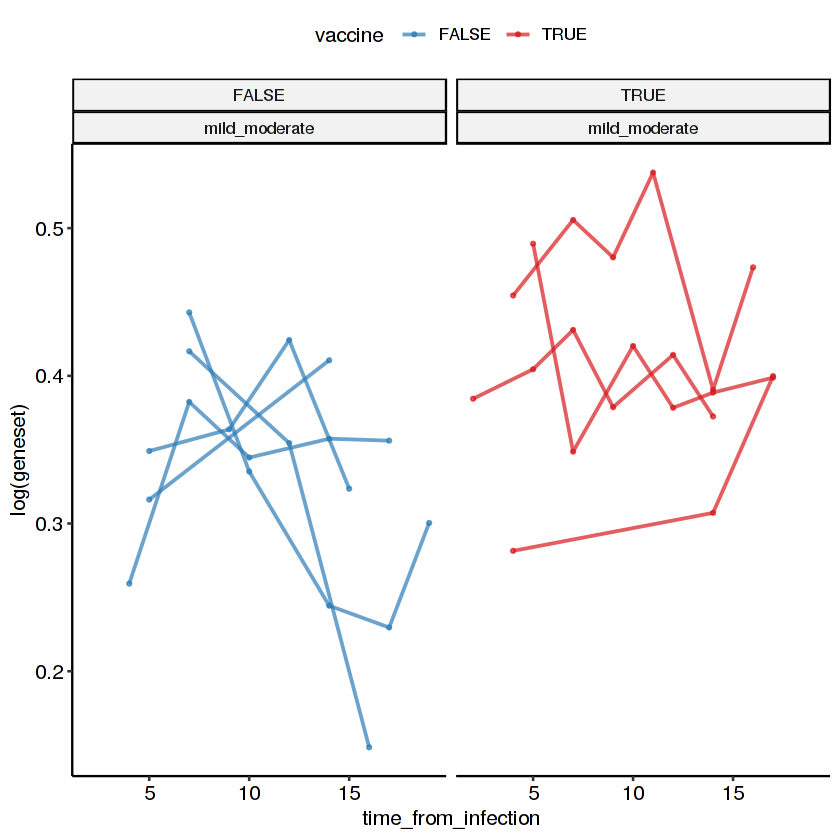

In [132]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

In [133]:
names(genelists)[[25]]

[1] "KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY"

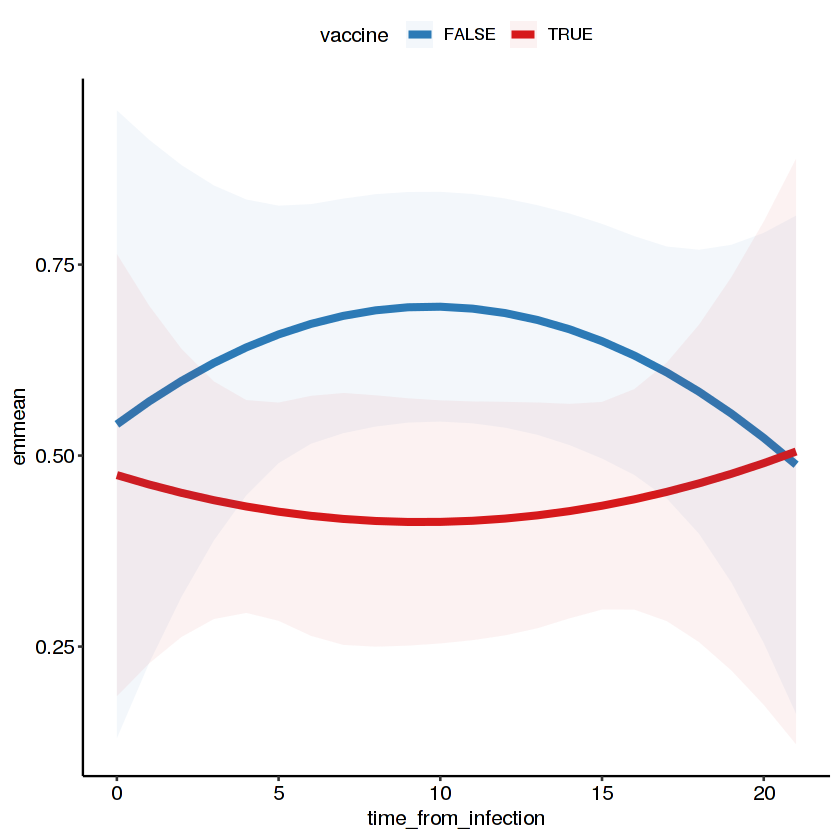

In [134]:
i = 25
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
    geom_line(aes(colour = vaccine), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

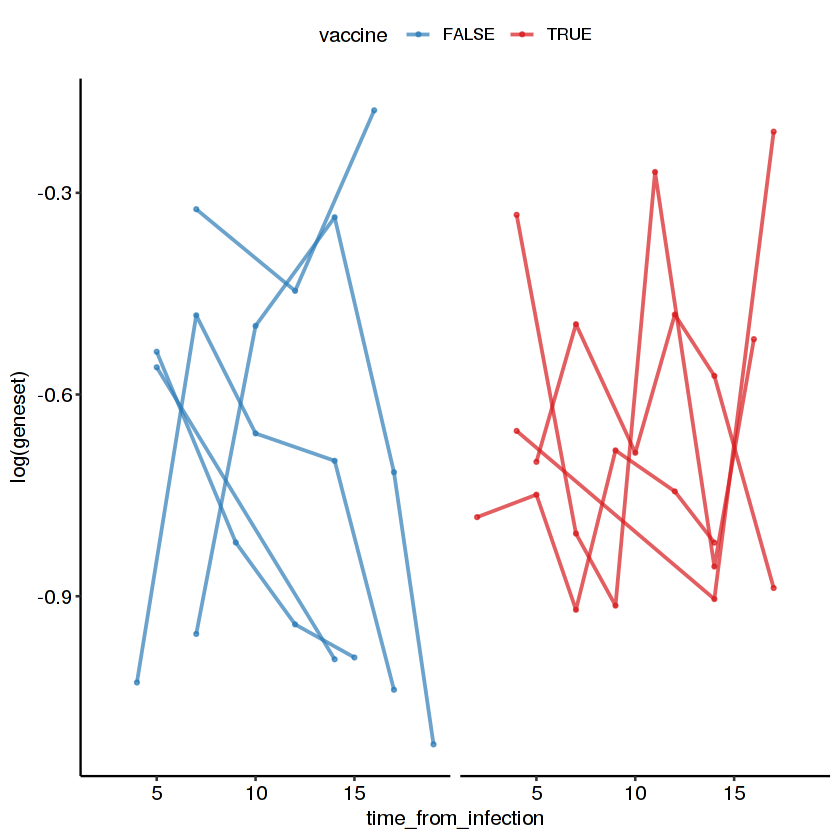

In [135]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

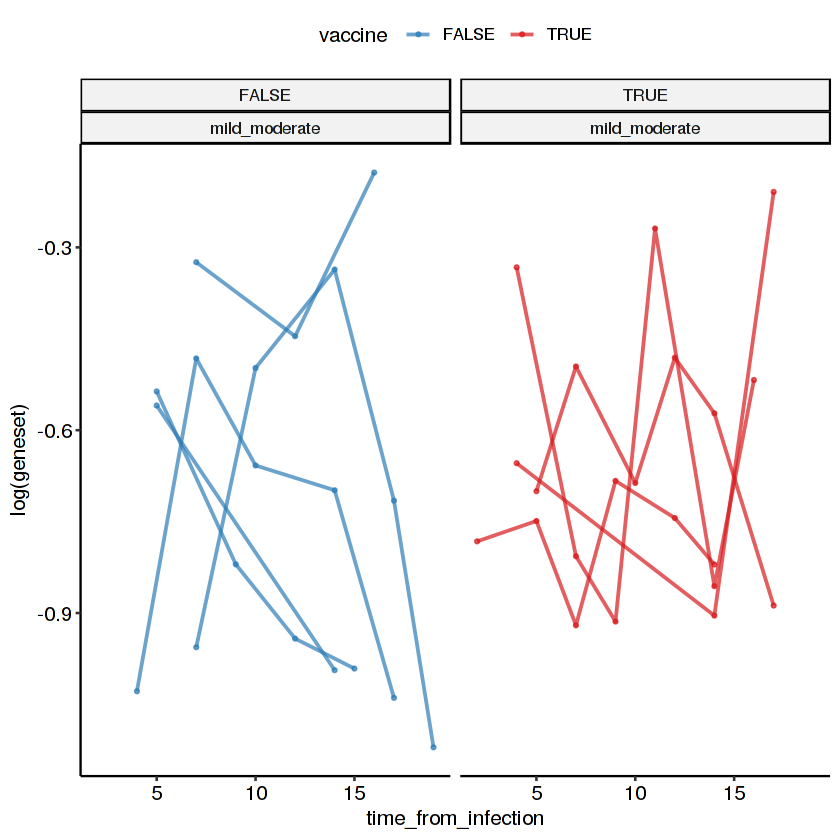

In [136]:
ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = vaccine)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~vaccine + grouped_severity) # +
    # theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())